In [ ]:
  project_id = 'cs229-414118'
!gcloud config set project {project_id}

import pandas as pd
import numpy as np

Updated property [core/project].


In [ ]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=WZBRMcqRNIxCGjbv1F4Oa29jfGBubI&prompt=consent&access_type=offline&code_challenge=o1xIBfEtp2fl_NwER1MlTMflAJRUTnkdqcv975PF-44&code_challenge_method=S256

Enter authorization code: 4/0AeaYSHAW5oE1Eq1Y0kaxiG8d2_g-H83Xin4Tb7q9yTRLuSMdH1RWQv09GpP8hdIY7AFpLA

You are now logged in as [lauren.cooper503@gmail.com].
Your current project is [cs229-414118].  You can change this setting by running:
  $ gcloud config set project P

In [ ]:
!gsutil -m cp -r "gs://cs229_data_sgl/anndata_predictions/*" bucket/anndata_predictions

# Modeling

### Common Functions

In [ ]:
from joblib import dump, load
import pandas as pd
import numpy as np
from tqdm import tqdm


def get_X(metadata, img_loc, adj_loc, pca_loc):
  loaded_pca = load(pca_loc)
  img_all = []
  adj_all = []
  with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
    for i, record in metadata.iterrows():
      patient, replicate = record[['patient','replicate']]
      img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col = [0,1,2])
      img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                   index = img_features.index,
                                   columns = [f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                   ) # no fitting
      adj_embedding = pd.read_csv(f'{adj_loc}/{patient}_{replicate}_adj_features.csv', index_col = [0,1,2])
      img_all.append(img_embedding)
      adj_all.append(adj_embedding)
      pbar.update(1)
  features = pd.concat([pd.concat(img_all), pd.concat(adj_all)],axis = 1)
  return features

def get_X_y(metadata, img_loc, adj_loc, pca_loc, top_genes_loc):

    # for obtaining y
    top_genes = pd.read_csv(top_genes_loc, header=None)[0].tolist()

    loaded_pca = load(pca_loc)
    img_all = []
    adj_all = []
    exp_data = []

    with tqdm(range(metadata.shape[0]), desc = 'Loading data') as pbar:
        for i, record in metadata.iterrows():
            patient, replicate = record[['patient', 'replicate']]

            # create the features from image and adjacency dataframes
            img_features = pd.read_csv(f'{img_loc}/{patient}_{replicate}_img_features.csv', index_col=[0, 1, 2])
            img_embedding = pd.DataFrame(loaded_pca.transform(img_features),
                                         index=img_features.index,
                                         columns=[f'img_feature_{j}' for j in range(loaded_pca.n_components)]
                                         )  # no fitting
            adj_embedding = pd.read_csv(f'{adj_loc}/{patient}_{replicate}_adj_features.csv', index_col=[0, 1, 2])
            img_all.append(img_embedding)
            adj_all.append(adj_embedding)

            # Now create the gene expression dataframe with spot information
            # Load gene expression data
            df_expression = pd.read_csv(f'bucket/stdata/{patient}_{replicate}_stdata.tsv.gz', sep='\t', index_col=0, compression='gzip')[top_genes]
            df_coordinates = pd.read_csv(f'bucket/spots/{record["spot_coordinates"]}', sep=',', index_col=0, compression='gzip')

            # Find common labels (spot IDs)
            common_labels = df_expression.index.intersection(df_coordinates.index)
            # Adjusted to ensure indexing consistency
            # The trick here is to ensure df_expression is correctly indexed before appending
            df_expression_filtered = df_expression.loc[common_labels]
            df_expression_filtered = df_expression_filtered.assign(Patient=patient, Replicate=replicate).set_index(['Patient', 'Replicate'],\
                                                                                                                   append=True).reorder_levels(['Patient', 'Replicate', df_expression_filtered.index.name])

            exp_data.append(df_expression_filtered)

            pbar.update(1)


    features = pd.concat([pd.concat(img_all), pd.concat(adj_all)], axis=1)
    y = pd.concat(exp_data)

    return features, y

# example use: train_X, train_y = get_X_y(train_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)

In [ ]:
# Code for analysis later

import anndata as ad
import scanpy as sc
from PIL import Image
import numpy as np
import squidpy as sq

def add_image_to_anndata(adata, image_path):

    # Open the image using PIL
    image = Image.open(image_path)
    image_array = np.array(image)


    # Store the image in the AnnData's .uns attribute
    # It's stored under 'image_data'; use a different key if storing multiple images
    spatial_key = 'spatial'
    library_id = 'histology'
    adata.uns[spatial_key] = {library_id: {}}
    adata.uns[spatial_key][library_id]['images']={}
    adata.uns[spatial_key][library_id]['images']={'hires': image_array}
    adata.uns[spatial_key][library_id]['scalefactors'] = {
        'tissue_hires_scalef': 1,
        'spot_diameter_fullres': 200,
    }


/usr/local/lib/python3.10/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spatialdata/__init__.py:11: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


## Baseline Modeling

### Get model data

In [ ]:
import pandas as pd

train_metadata = pd.read_csv('bucket/train_metadata.csv', index_col = 0)
valid_metadata = pd.read_csv('bucket/valid_metadata.csv', index_col = 0)
#test_metadata = pd.read_csv('bucket/test_metadata.csv', index_col = 0)

run_name = 'simple_baseline'
img_loc = f'bucket/datasets/{run_name}/preprocessed_img'
adj_loc= f'bucket/datasets/{run_name}/aligned_svd_features'
pca_loc = f'bucket/models/{run_name}/image_pca_resnet_32.joblib'
top_genes_loc = f'bucket/top_250_genes_new.txt'

train_X, train_y_full = get_X_y(train_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)
valid_X, valid_y_full = get_X_y(valid_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)
#test_X, test_y_full = get_X_y(test_metadata, img_loc, adj_loc, pca_loc, top_genes_loc)

Loading data: 100%|██████████| 15/15 [02:12<00:00,  8.84s/it]


## Observing the data

This code will modify the adata objects to show the predictions for plotting. Still working on this portion.

This code also uses train_X and train_y with the same data structure

By running create_adata(train_y_full, patient, replicate) we can add the ground truth top 250 genes from the training dataset to the adata objects for a specific patient/replicate.

Again, there are some issues with the adata calculation above. Coming back to in a second.

In [ ]:
adata

AnnData object with n_obs × n_vars = 256 × 16744
    obs: 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mean_counts', 'mean_poisson_expression', 'poisson_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'poisson_predictions', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

<ipython-input-5-93553af104f7>:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  counts = train_y_df.loc[patient,replicate]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (91769216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


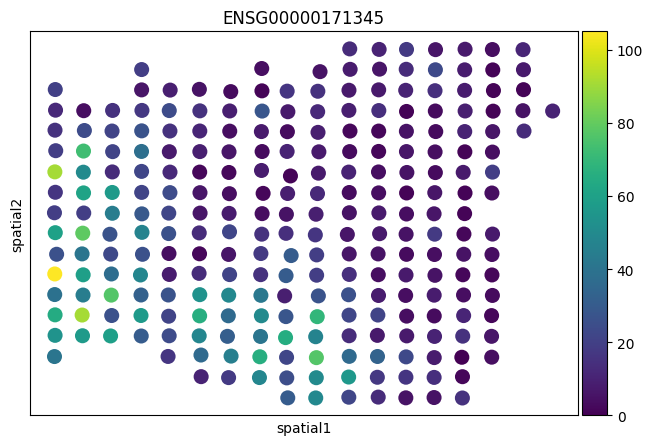

In [ ]:
patient = 'BC23287'
replicate = 'C1'

adata_test = create_adata(train_y_full, patient, replicate)

gene = 'ENSG00000171345'  # The gene of interest
sc.pl.scatter(adata_test, basis='spatial', color=gene)

/usr/local/lib/python3.10/dist-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


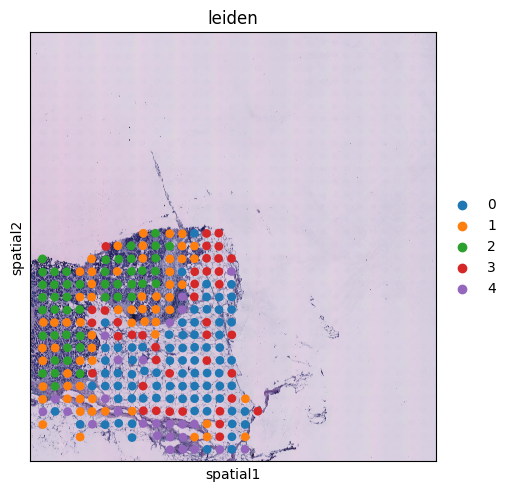

In [ ]:
sq.pl.spatial_scatter(adata_test, color='leiden')

To run the following code requires calculating total counts and n genes by counts first

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

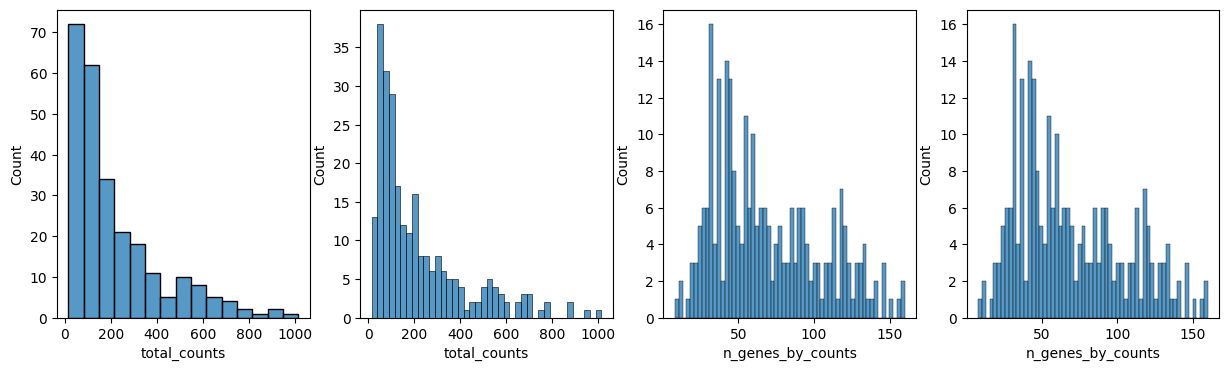

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata_test.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(adata_test.obs["total_counts"][adata_test.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.histplot(adata_test.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(adata_test.obs["n_genes_by_counts"][adata_test.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

## Running the regression

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Ensure train_X and valid_X have a constant column for the intercept
X_train_const = sm.add_constant(train_X)
X_valid_const = sm.add_constant(valid_X)

# Initialize a dictionary to store models (optional) and another for predictions
models = {}  # Optional: Store each gene's model if needed for future reference
valid_predictions = {}
train_predictions = {}

for gene in train_y_full.columns:
    # Train model
    y_train = train_y_full[gene]
    model = sm.GLM(y_train, X_train_const, family=sm.families.NegativeBinomial()).fit()
    models[gene] = model  # Optional: Save the model

    # Predict using the trained model
    valid_predictions[gene] = model.predict(X_valid_const)
    train_predictions[gene] = model.predict(X_train_const)

# Convert predictions dictionary to DataFrame
valid_predictions_df = pd.DataFrame(valid_predictions, index=valid_X.index)
train_predictions_df = pd.DataFrame(train_predictions, index=train_X.index)


Results: prediction on validation set versus ground truth

<ipython-input-5-93553af104f7>:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  counts = train_y_df.loc[patient,replicate]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (92180074 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


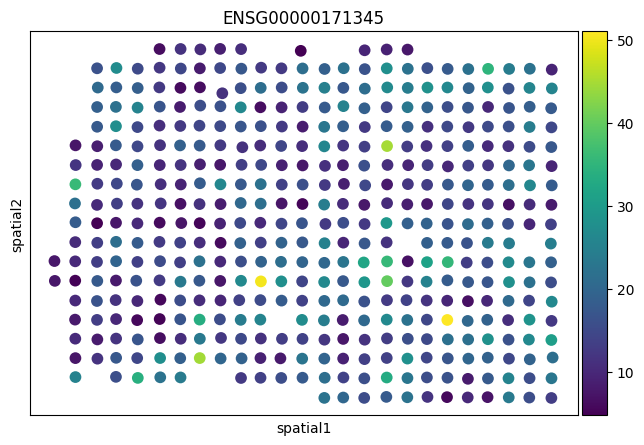

In [ ]:
patient = 'BC23803'
replicate = 'E2'
adata_predict = create_adata(valid_predictions_df, patient, replicate)
gene = 'ENSG00000171345'  # The gene of interest
sc.pl.scatter(adata_predict, basis='spatial', color=gene)

## Export Predictions

In [ ]:
def update_adata(train_y_df, predictions_y_df, patient, replicate, model_name):
    # this function requires you to pick a specific patient and replicate
    # then it uses the spots as the indices
    # the patient has to be in both the original data and predictions to work
    # requires you to tell it the model name so when you're working with adata
    # object it's clear which model was used

    # look up image file name and spot file name
    metadata_df = pd.read_csv('bucket/metadata.csv')
    patient_data = metadata_df[(metadata_df['patient'] == patient) & (metadata_df['replicate'] == replicate)]
    image_filename = patient_data['histology_image'].iloc[0] if not patient_data.empty else None
    spot_filename = patient_data['spot_coordinates'].iloc[0] if not patient_data.empty else None
    adata_path = f'bucket/anndata/{patient}_{replicate}.h5ad'


    # match expression with coordinates
    counts = train_y_df.loc[patient,replicate]
    coordinates = pd.read_csv(f'bucket/spots/{spot_filename}', sep=',', index_col=0, compression='gzip')
    coordinates = coordinates.loc[counts.index]

    # obtain the adata object
    adata = ad.read_h5ad(f'bucket/anndata/{patient}_{replicate}.h5ad')

    # calculate QC metrics
    cell_metrics, gene_metrics = sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=False)
    adata.obs = adata.obs.join(cell_metrics)
    # Calculate mean counts per cell (total_counts / number of genes)
    adata.obs['mean_counts'] = adata.obs['total_counts'] / adata.n_vars

    # add image for spatial map
    add_image_to_anndata(adata,f'bucket/images/{image_filename}')

    # add predictions to adata object
    adata.obsm[f'{model_name}_predictions'] = predictions_y_df.loc[patient,replicate]

    # perform calculations on predictions
    # Calculate mean expression level across genes for each spot
    mean_expression_levels = np.mean(adata.obsm[f'{model_name}_predictions'], axis=1)
    adata.obs[f'mean_{model_name}_expression'] = mean_expression_levels
    # Sum across genes for each spot to get total predicted counts
    predicted_total_counts = np.sum(adata.obsm[f'{model_name}_predictions'], axis=1)
    adata.obs[f'{model_name}_total_counts'] = predicted_total_counts

    return adata

In [ ]:
import os

def export_adata_predictions(model_name, metadata_path, output_path, data_type, truth, predictions):

  # Ensure the output directory exists
  output_dir = output_path
  os.makedirs(output_dir, exist_ok=True)
  print('test1')
  # Load the metadata
  metadata_df = pd.read_csv(metadata_path)

  print('test2')
  n = 1
  # Loop through each row in the metadata DataFrame
  for idx, row in metadata_df.iterrows():
      patient = row['patient']
      replicate = row['replicate']
      print(patient+'_'+replicate)

      if os.path.exists(f'{output_dir}{data_type}_{patient}_{replicate}_adata.h5ad'):
        print('already calculated')
        continue

      # Call your function to update/create the AnnData object
      adata_updated = update_adata(truth, predictions, patient, replicate, model_name)

      # Construct a unique filename for each AnnData object
      filename = f"{output_dir}{data_type}_{patient}_{replicate}_adata.h5ad"

      # Save the updated adata object
      adata_updated.write(filename)

      print(f"Saved {filename}")
      n = n + 1
      print(n)

      if n == 5:
        break


In [ ]:
model_name = 'NB'
metadata_path = 'bucket/train_metadata.csv'
data_type = 'train'
output_path = 'bucket/anndata_predictions/'
export_adata_predictions(model_name, metadata_path, output_path, data_type, train_y_full, train_predictions_df)

test1
test2
BC23287_C1


<ipython-input-7-31734d9117a7>:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  counts = train_y_df.loc[patient,replicate]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (91769216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
<ipython-input-7-31734d9117a7>:34: PerformanceWarning: indexing past lexsort depth may impact performance.
  adata.obsm[f'{model_name}_predictions'] = predictions_y_df.loc[patient,replicate]


Saved bucket/anndata_predictions/train_BC23287_C1_adata.h5ad
2
BC23287_C2


<ipython-input-7-31734d9117a7>:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  counts = train_y_df.loc[patient,replicate]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (91985625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
<ipython-input-7-31734d9117a7>:34: PerformanceWarning: indexing past lexsort depth may impact performance.
  adata.obsm[f'{model_name}_predictions'] = predictions_y_df.loc[patient,replicate]


Saved bucket/anndata_predictions/train_BC23287_C2_adata.h5ad
3
BC23287_D1


<ipython-input-7-31734d9117a7>:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  counts = train_y_df.loc[patient,replicate]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (91621935 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
<ipython-input-7-31734d9117a7>:34: PerformanceWarning: indexing past lexsort depth may impact performance.
  adata.obsm[f'{model_name}_predictions'] = predictions_y_df.loc[patient,replicate]


Saved bucket/anndata_predictions/train_BC23287_D1_adata.h5ad
4
BC23901_C2


<ipython-input-7-31734d9117a7>:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  counts = train_y_df.loc[patient,replicate]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (92181496 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
<ipython-input-7-31734d9117a7>:34: PerformanceWarning: indexing past lexsort depth may impact performance.
  adata.obsm[f'{model_name}_predictions'] = predictions_y_df.loc[patient,replicate]


Saved bucket/anndata_predictions/train_BC23901_C2_adata.h5ad
5


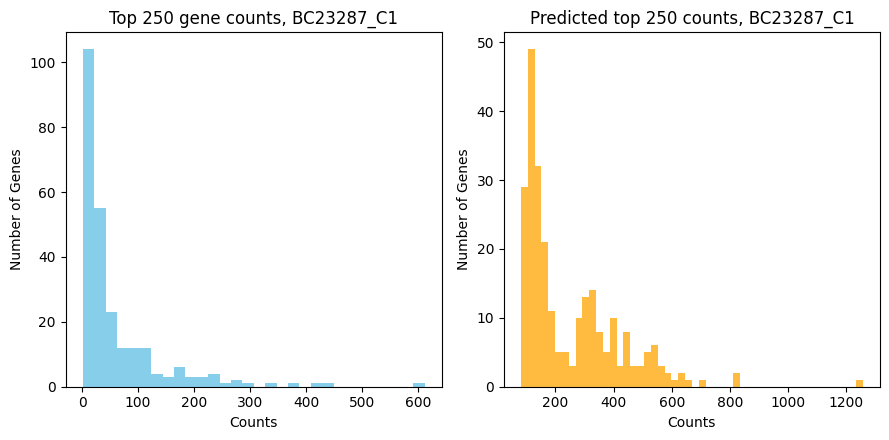

In [ ]:
patient = 'BC23287'
replicate = 'C1'
histogram_compare(patient, replicate, 'train', 'NB', top_genes)

In [ ]:
model_name = 'NB'
metadata_path = 'bucket/valid_metadata.csv'
data_type = 'valid'
output_path = 'bucket/anndata_predictions'
export_adata_predictions(model_name, metadata_path, data_type, valid_y_full, valid_predictions_df)

## More plotting

Analyze just the top 250 genes

In [ ]:
# Load the list of top 250 genes from a text file
top_genes_filename = 'bucket/top_250_genes_new.txt'

with open(top_genes_filename, 'r') as f:
    top_genes = [line.strip() for line in f.readlines()]

In [ ]:
import scipy as sc
import matplotlib.pyplot as plt

def histogram_compare(patient, replicate, data_type, model, top_genes):
  adata = ad.read_h5ad(f'bucket/anndata_predictions/{data_type}_{patient}_{replicate}_adata.h5ad')

  # Filter the adata object to keep only the top 250 genes
  top_genes_adata = adata[:, adata.var_names.isin(top_genes)]

  # Sum the counts for each gene across all cells
  gene_counts = np.sum(top_genes_adata.X, axis=0)

  # If your data is stored in a sparse matrix format, you might need to convert it to a dense format before summing
  if sc.sparse.issparse(top_genes_adata.X):
      gene_counts = np.sum(top_genes_adata.X.toarray(), axis=0)

  # Create a figure and a 1x2 grid of subplots (1 row, 2 columns)
  fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

  # Plot on the first subplot
  axs[0].hist(gene_counts, bins=30, color='skyblue')
  axs[0].set_title(f'Top 250 gene counts, {patient}_{replicate}')
  axs[0].set_xlabel('Counts')
  axs[0].set_ylabel('Number of Genes')

  # Plot on the second subplot
  axs[1].hist(adata.obs[f'{model}_total_counts'], bins=50, alpha=0.75, color='orange')  # Assuming gene_counts2 for demonstration
  axs[1].set_title(f'Predicted top 250 counts, {patient}_{replicate}')
  axs[1].set_xlabel('Counts')
  axs[1].set_ylabel('Number of Genes')

  # Adjust layout to prevent overlap
  plt.tight_layout()

  # Display the plots
  plt.show()



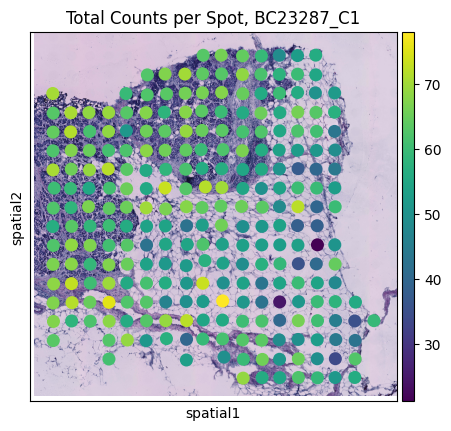

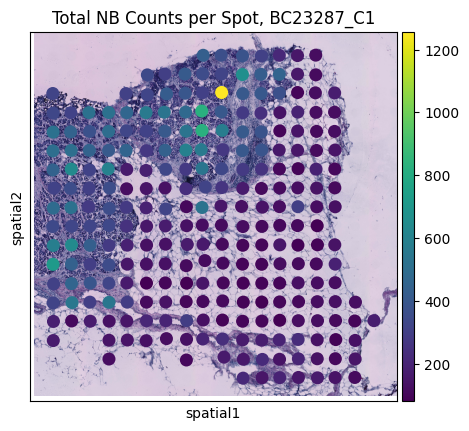

In [ ]:
patient = 'BC23287'
replicate = 'C1'
data_type = 'train'
model_type = 'NB'

spatial_top_250_compare(patient, replicate, data_type, model_type, 'sum', top_genes)

In [ ]:
import scanpy as sc

def spatial_top_250_compare(patient, replicate, data_type, model_type, stats, top_genes):

  # data_type will tell you whether the adata is a train or test object
  # stats will tell you what type of coloration to use on the spatial plot
  # aka will the coloring represent total counts, average counts, etc

  adata = ad.read_h5ad(f'bucket/anndata_predictions/{data_type}_{patient}_{replicate}_adata.h5ad')

  # Filter the `adata` object to keep only the top 250 genes.
  # Ensure that `top_genes` is a list of gene names as strings.
  filtered_adata = adata[:, adata.var_names.isin(top_genes)]
  adata.obsm['top_250_genes'] = filtered_adata.X

  if stats == 'sum':
    gene_counts_sum = adata.obsm['top_250_genes'].sum(axis=1)

    # normalization factor
    scale_truth = np.mean(gene_counts_sum)

    # normalize the counts
    normalized_gene_counts_sum = gene_counts_sum / scale_truth
    # Store the normalized sums in adata.obs
    adata.obs['top_250_gene_counts_normalized_sum'] = normalized_gene_counts_sum

    min = np.min(normalized_gene_counts_sum)
    max = np.percentile(normalized_gene_counts_sum, 95)

    # Plot ground truth
    sc.pl.spatial(adata, color='top_250_gene_counts_normalized_sum', title = f'Total Counts per Spot, {patient}_{replicate}', vmin = min, vmax = max)

    # Sum the predictions across genes (columns) for each spot (row)
    prediction_sums = np.sum(adata.obsm[f'{model_type}_predictions'], axis=1)

    # normalization factor
    scale_predict = np.mean(prediction_sums)

    # Normalize the prediction sums by the mean
    normalized_prediction_sums = prediction_sums / scale_predict

    min = np.min(normalized_prediction_sums)
    max = np.percentile(normalized_prediction_sums, 95)

    # Store the normalized prediction sums in adata.obs
    adata.obs[f'{model_type}_prediction_normalized_sum'] = normalized_prediction_sums


    # Plot predictions for top 250, summed
    sc.pl.spatial(adata, color=f'{model_type}_prediction_normalized_sum', title=f'Total {model_type} Counts per Spot, {patient}_{replicate}', vmin = min, vmax = max)

  elif stats == 'mean':

    gene_counts_mean = np.mean(adata.obsm['top_250_genes'], axis=1)
    # Add the mean counts to adata.obs
    adata.obs['top_250_gene_counts_mean'] = gene_counts_mean

    # Plot Ground Truth
    sc.pl.spatial(adata, color='top_250_gene_counts_mean', title = f'Average Counts per Spot, {patient}_{replicate}')

    # Sum the predictions across genes (columns) for each spot (row)
    prediction_mean = np.mean(adata.obsm[f'{model_type}_predictions'], axis=1)
    adata.obs['prediction_mean'] = prediction_mean

    # Plot predictions for top 250, averaged
    sc.pl.spatial(adata, color='prediction_mean', title=f'Average Prediction Counts per Spot, {patient}_{replicate}')

  else:
    'what type of plot?'



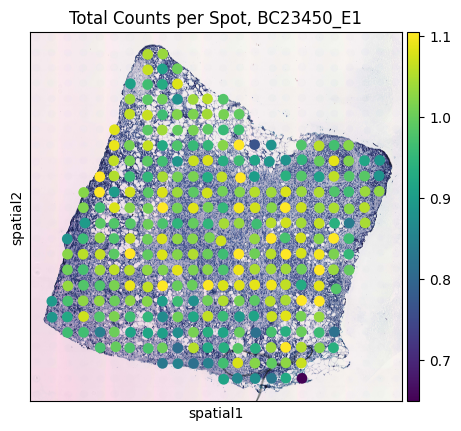

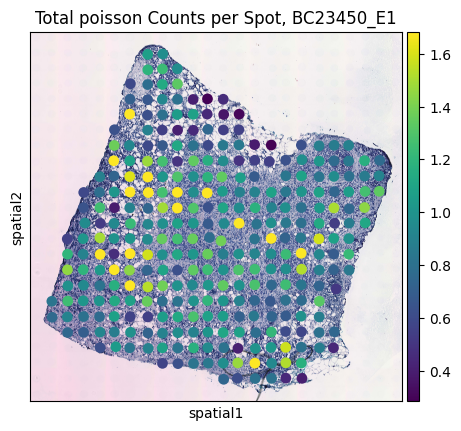

In [ ]:
patient = 'BC23450'
replicate = 'E1'
data_type = 'valid'
model_type = 'poisson'
spatial_top_250_compare(patient, replicate, data_type, model_type, 'sum', top_genes)

In [ ]:
def histogram_cluster_compare(patient, replicate, data_type, top_genes):
    adata = ad.read_h5ad(f'bucket/anndata_predictions/{data_type}_{patient}_{replicate}_adata.h5ad')

    # Filter the adata object to keep only the top 250 genes
    top_genes_adata = adata[:, adata.var_names.isin(top_genes)]

    # Convert to dense format if necessary
    X_dense = top_genes_adata.X.toarray() if scipy.sparse.issparse(top_genes_adata.X) else top_genes_adata.X

    # Ground Truth:------------------------------
    # Calculate total gene counts for each Leiden cluster
    clusters = adata.obs['leiden'].unique()
    cluster_totals = {}

    for cluster in clusters:
        indices = (adata.obs['leiden'] == cluster)
        cluster_totals[cluster] = X_dense[indices].sum(axis=0).sum()

    # Convert cluster keys to integers for numeric sorting, if they are not already
    cluster_keys_numeric = sorted([int(cluster) for cluster in cluster_totals.keys()])

    # Reorder cluster_totals based on sorted numeric keys
    cluster_totals_sorted = {str(cluster): cluster_totals[str(cluster)] for cluster in cluster_keys_numeric}

    # Predictions:--------------------------------
    predictions = adata.obsm['poisson_predictions']
    predictions['cluster'] = adata.obs['leiden'].values

    # Sum predictions across all genes for each cluster
    total_predicted_counts_per_cluster = predictions.groupby('cluster').sum().sum(axis=1)


    # Reset index to make 'cluster' a column (useful for plotting)
    total_counts_df = total_predicted_counts_per_cluster.reset_index()
    total_counts_df.columns = ['Cluster', 'Total Predicted Counts']

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plotting total gene counts per Leiden cluster with sorted clusters
    axs[0].bar(range(len(cluster_totals_sorted)), list(cluster_totals_sorted.values()), color='purple')
    axs[0].set_title(f'Total Gene Counts per Leiden Cluster, {patient}_{replicate}')
    axs[0].set_xticks(range(len(cluster_totals_sorted)))
    axs[0].set_xticklabels(list(cluster_totals_sorted.keys()), rotation=45)
    axs[0].set_xlabel('Leiden Cluster')
    axs[0].set_ylabel('Total Counts')

    # Plotting total predicted counts per cluster on the first subplot
    axs[1].bar(total_counts_df['Cluster'], total_counts_df['Total Predicted Counts'], color='teal')
    axs[1].set_xlabel('Leiden Cluster')
    axs[1].set_ylabel('Total Predicted Counts')
    axs[1].set_title('Total Predicted Counts per Leiden Cluster')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

<ipython-input-144-38d6fdacfa0e>:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_predicted_counts_per_cluster = predictions.groupby('cluster').sum().sum(axis=1)


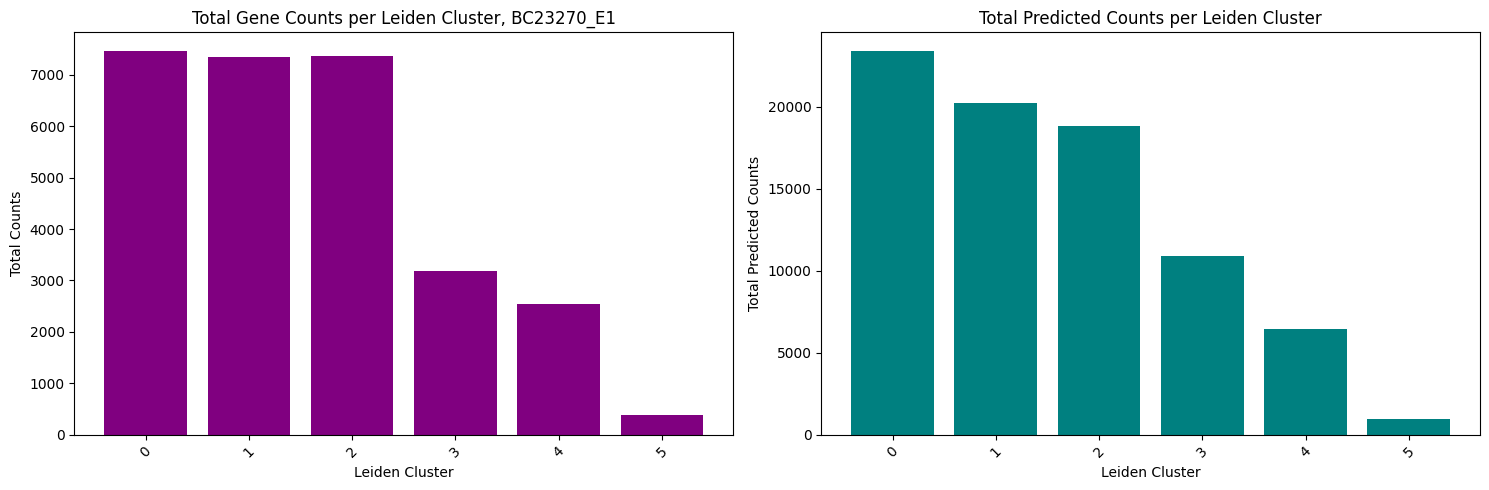

In [ ]:
patient = 'BC23270'
replicate = 'E1'
data_type = 'train'
histogram_cluster_compare(patient, replicate, data_type, top_genes)

In [ ]:
import scanpy as sc
import numpy as np
import anndata as ad

def spatial_gene_compare(patient, replicate, data_type, top_genes, gene_name):
    adata = ad.read_h5ad(f'bucket/anndata_predictions/{data_type}_{patient}_{replicate}_adata.h5ad')

    # Ensure gene_name is among the top_genes
    if gene_name not in top_genes:
        print(f"{gene_name} is not in the list of top genes. Please check the gene name.")
        return

    # Filter the `adata` object to keep only the top 250 genes.
    filtered_adata = adata[:, adata.var_names.isin(top_genes)]

    # Find the index of 'gene_1' in the filtered dataset
    gene_index = np.where(filtered_adata.var_names == gene_name)[0]

    if len(gene_index) == 0:
        print(f"Gene {gene_name} not found in the dataset.")
        return
    gene_index = gene_index[0]  # Extract the single index from the array

    # Extract counts for 'gene_1'
    adata.obs[f'{gene_name}_counts'] = filtered_adata.X[:, gene_index].toarray().flatten() if scipy.sparse.issparse(filtered_adata.X) else filtered_adata.X[:, gene_index]
    print(adata.obs[f'{gene_name}_counts'])
    # Plot ground truth for 'gene_1'
    sc.pl.spatial(adata, color=f'{gene_name}_counts', title=f"Counts of {gene_name}, {patient}_{replicate}")

    # Assuming predictions are stored in a DataFrame within `adata.obsm`
    predictions_df = adata.obsm['poisson_predictions']
    if gene_name in predictions_df.columns:
        # Extract predicted counts for 'gene_1'
        adata.obs[f'{gene_name}_prediction_counts'] = predictions_df[gene_name]

        # Plot predictions for 'gene_1'
        sc.pl.spatial(adata, color=f'{gene_name}_prediction_counts', title=f"Predicted Counts of {gene_name}, {patient}_{replicate}")
    else:
        print(f"Predictions for {gene_name} not found in the predictions dataframe.")


ModuleNotFoundError: No module named 'scanpy'

23x20   NaN
23x21   NaN
23x23   NaN
23x24   NaN
24x19   NaN
         ..
13x19   NaN
13x16   NaN
13x17   NaN
13x14   NaN
9x30    NaN
Name: ENSG00000132507_counts, Length: 284, dtype: float64


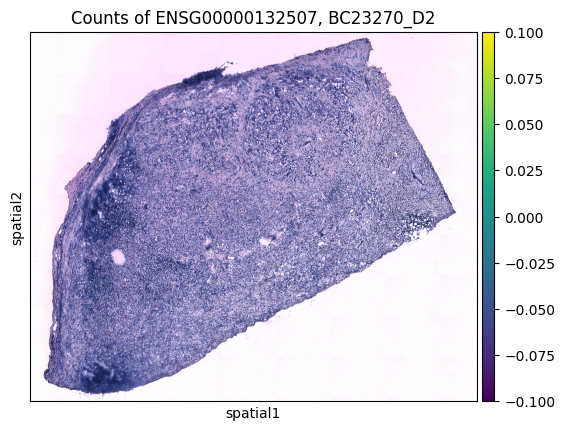

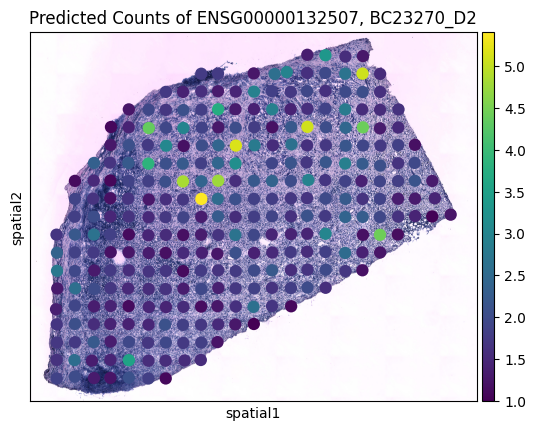

In [ ]:
patient = 'BC23270'
replicate = 'D2'
data_type = 'train'
gene_name = top_genes[40]
spatial_gene_compare(patient, replicate, data_type, top_genes, gene_name)